In [1]:
# !pip install pandas matplotlib tabulate
import subprocess
import pandas as pd
import json
import matplotlib.pyplot as plt

metadata = []
with open("bug_portfolio/metadata.jsonl", "r") as f:
    buffer = ""
    for line in f:
        line = line.strip()
        if not line:
            continue
        buffer += line
        if line.endswith("}"):
            try:
                metadata.append(json.loads(buffer))
            except json.JSONDecodeError:
                pass
            buffer = ""

bug_map = {item["name"]: item.get("bug_description", "No description provided") for item in metadata}
functions = [item["name"] for item in metadata]

# Create mapping from function name to bug description
bug_map = {item["name"]: item.get("bug_description", "No description provided") for item in metadata}
functions = [item["name"] for item in metadata]

print(functions)
print(len(functions))

['set_Right_most_Unset_Bit', 'find_Max', 'gold_mine_problem', 'sumofFactors', 'first_Digit', 'find_max_val', 'check_Validity', 'bitonic_subsequence', 'binomial_Coeff', 'bell_Number', 'max_chain_length', 'sum_Of_Primes', 'max_run_uppercase', 'sort_by_dnf', 'pass_validity', 'check_Type_Of_Triangle', 'count_Pairs', 'generate_matrix', 'count_duplic', 'is_subset', 'find_first_occurrence', 'longest_increasing_subsequence']
22


In [10]:
llm_found = {}
human_found = {}

for func in functions:
    if func != "find_first_occurrence":
        continue
    print(f"\n=== Testing `{func}` ===")
    print(f"Bug Description: {bug_map[func]}")

    # --- Run LLM-generated tests ---
    test_file = f"llm_tests/generated_tests/test_{func}.py"
    result = subprocess.run(
        ["pytest", "-q", test_file],
        capture_output=True,
        text=True
    )

    found = (result.returncode != 0)
    llm_found[func] = found
    status = "found" if found else "not found"

    print(f"LLM tests for `{func}`: Bug {status} (exit code {result.returncode})")
    print("---- LLM TEST OUTPUT ----")
    print(result.stdout)
    if result.stderr.strip():
        print("---- LLM TEST ERRORS ----")
        print(result.stderr)

    # --- Run Human-written tests ---
    test_file = f"human_tests/test_{func}.py"
    result = subprocess.run(
        ["pytest", "-q", test_file],
        capture_output=True,
        text=True
    )

    found = (result.returncode != 0)
    human_found[func] = found
    status = "found" if found else "not found"

    print(f"Human tests for `{func}`: Bug {status} (exit code {result.returncode})")
    print("---- HUMAN TEST OUTPUT ----")
    print(result.stdout)
    if result.stderr.strip():
        print("---- HUMAN TEST ERRORS ----")
        print(result.stderr)



=== Testing `find_first_occurrence` ===
Bug Description: The condition 'elif x < A[mid] - 1:' should be 'elif x < A[mid]:'.
LLM tests for `find_first_occurrence`: Bug not found (exit code 0)
---- LLM TEST OUTPUT ----
............                                                             [100%]
12 passed in 0.47s

Human tests for `find_first_occurrence`: Bug found (exit code 1)
---- HUMAN TEST OUTPUT ----
....F                                                                    [100%]
================================== FAILURES ===================================
___________________________ test_monotonic_property ___________________________

    @given(st.lists(st.integers(), min_size=1).map(sorted), st.integers())
>   def test_monotonic_property(A, x):
                   ^^^

human_tests\test_find_first_occurrence.py:71: 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

A = [15, 16, 16], x = 15

    @given(st.lists(st.integers(), min_size=1).map(sorte

In [7]:
results = []
for func in functions:
    results.append({
        "Function": func,
        "LLM Found": "Yes" if llm_found.get(func, False) else "No",
        "Human Found": "Yes" if human_found.get(func, False) else "No"
    })

df = pd.DataFrame(results)



# Manually update any function’s results here:
# df.loc[df['Function'] == 'gold_mine_problem', 'LLM Found'] = 'No'
# df.loc[df['Function'] == 'set_Right_most_Unset_Bit', 'Human Found'] = 'Yes'
# Uncomment and edit as needed

# ---- Manual overrides go here ----
# df.loc[df['Function'] == 'gold_mine_problem', 'LLM Found'] = 'No'
# df.loc[df['Function'] == 'set_Right_most_Unset_Bit', 'Human Found'] = 'Yes'
# ----------------------------------

print("### Individual Test Results\n")
print(df.to_markdown(index=False))

### Individual Test Results

| Function                       | LLM Found   | Human Found   |
|:-------------------------------|:------------|:--------------|
| set_Right_most_Unset_Bit       | Yes         | Yes           |
| find_Max                       | No          | Yes           |
| gold_mine_problem              | Yes         | Yes           |
| sumofFactors                   | Yes         | Yes           |
| first_Digit                    | No          | Yes           |
| find_max_val                   | No          | Yes           |
| check_Validity                 | Yes         | Yes           |
| bitonic_subsequence            | Yes         | Yes           |
| binomial_Coeff                 | Yes         | Yes           |
| bell_Number                    | Yes         | Yes           |
| max_chain_length               | Yes         | No            |
| sum_Of_Primes                  | No          | Yes           |
| max_run_uppercase              | Yes         | Yes         

In [4]:
only_llm = ((df["LLM Found"] == "Yes") & (df["Human Found"] == "No")).sum()
only_human = ((df["LLM Found"] == "No") & (df["Human Found"] == "Yes")).sum()
both = ((df["LLM Found"] == "Yes") & (df["Human Found"] == "Yes")).sum()
neither = ((df["LLM Found"] == "No") & (df["Human Found"] == "No")).sum()

scorecard = pd.DataFrame({
    "Metric": [
        "Bugs found only by LLM tests",
        "Bugs found only by Human properties",
        "Bugs found by both",
        "Bugs found by neither"
    ],
    "Count": [only_llm, only_human, both, neither]
})

print("\n\n### Final Scorecard\n")
print(scorecard.to_markdown(index=False))


# === STEP 4: Optional — Save both tables to CSV (for report) ===
df.to_csv("results_summary.csv", index=False)
scorecard.to_csv("final_scorecard.csv", index=False)




### Final Scorecard

| Metric                              |   Count |
|:------------------------------------|--------:|
| Bugs found only by LLM tests        |       2 |
| Bugs found only by Human properties |       6 |
| Bugs found by both                  |      14 |
| Bugs found by neither               |       0 |


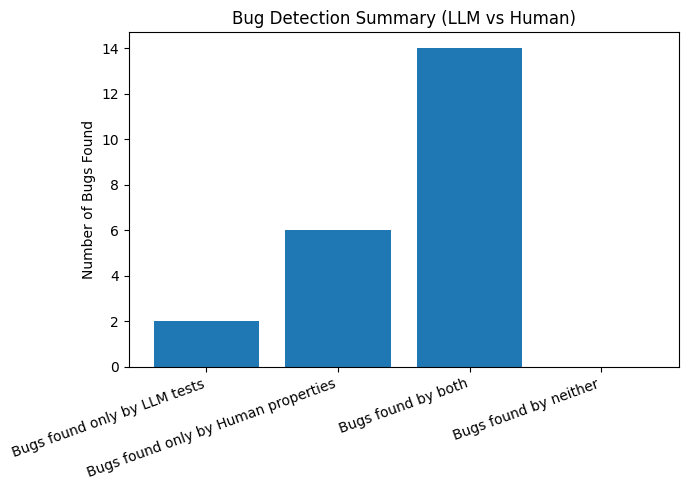

In [5]:
plt.figure(figsize=(7,5))
plt.bar(scorecard["Metric"], scorecard["Count"])
plt.title("Bug Detection Summary (LLM vs Human)")
plt.ylabel("Number of Bugs Found")
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()